# Homework 11: Classification

**Reading**: 

* [Classification](https://www.inferentialthinking.com/chapters/17/Classification.html)


Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell. 

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. 

For all problems that you must write out explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework, please be sure to not re-assign variables throughout the notebook! For example, if you use `max_temperature` in your answer to one question, do not reassign it later on.

In [5]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. Carolina vs Duke Fans by Location with Classification


Dr McLean is trying classify residents of North Carolina as being fans of (or at least preferring) either the University of North Carolina at Chapel Hill or Duke. To classify the residents, Dr McLean has access to survey data containing the coordinates of the locations where survey respondants live, as well as if they are fans of Carolina or Duke. First, load in the `coordinates` table.

In [6]:
# Just run this cell!
coordinates = Table.read_table('coordinates23.csv')
coordinates.show(5)

latitude,longitude,school
36.0158,-78.7698,Duke
35.8757,-79.2824,Carolina
35.9113,-78.929,Carolina
35.9567,-78.9622,Carolina
35.9079,-79.0572,Duke


As usual, let's investigate our data visually before performing any kind of numerical analysis.

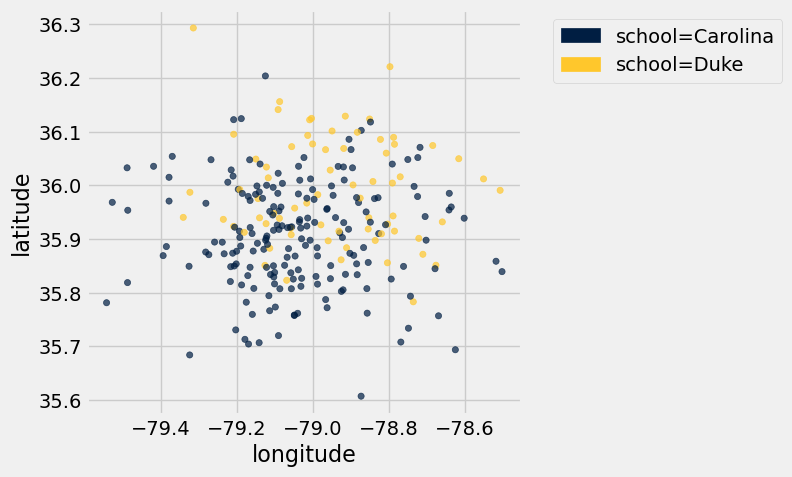

In [7]:
# Just run this cell!
coordinates.scatter("longitude", "latitude", group="school")

Run the following cell to see what these points correspond to on a map.

In [8]:
# Just run this cell!
colors = {"Carolina":"lightblue", "Duke":"blue"}
t = Table().with_columns("lat", coordinates.column(0), 
                                      "lon", coordinates.column(1), 
                                      "color", coordinates.apply(colors.get, 2)
                        )
Circle.map_table(t, radius=5, fill_opacity=1)

#### Question 1

Let's begin implementing the k-Nearest Neighbors algorithm. Define the `distance` function, which takes in two arguments: an array of numerical features, and a different array of numerical features. The function should return the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two arrays. Euclidean distance is often referred to as the straight-line distance formula that you may have learned previously.


<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

In [9]:
def distance(arr1, arr2):
    return np.sqrt(sum((arr1 - arr2)**2))

# Don't change/delete the code below in this cell
distance_example = distance(make_array(2, 4, 6), make_array(3, 5, 7))
distance_example

1.7320508075688772

### Splitting the dataset
We'll do 2 different kinds of things with the `coordinates` dataset:
1. We'll build a classifier using coordinates for which we know the associated label; this will teach it to recognize labels of similar coordinate values. This process is known as *training*.
2. We'll evaluate or *test* the accuracy of the classifier we build on data we haven't seen before.

For reasons discussed in lecture and the textbook, we want to use separate datasets for these two purposes.  So we split up our one dataset into two.

#### Question 2

Next, let's split our dataset into a training set and a test set. Since `coordinates` has $260$ rows, let's create a training set with 208 rows and a test set with the remaining 52 rows. Remember that assignment to each group should be random, so we should shuffle the table first.

*Hint: as a first step we can shuffle all the rows, then use the* `tbl.take` *function to split up the rows for each table*


<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

In [11]:
shuffled_table = coordinates.sample(with_replacement=False)
train = shuffled_table.take(np.arange(208))
test = shuffled_table.take(np.arange(208, 260))

print("Training set:\t",   train.num_rows, "examples")
print("Test set:\t",       test.num_rows, "examples")
train.show(5), test.show(5);

Training set:	 208 examples
Test set:	 52 examples


latitude,longitude,school
36.2038,-79.1251,Carolina
35.8585,-78.5173,Carolina
35.7943,-79.1159,Carolina
35.9513,-79.1136,Carolina
35.9504,-78.8597,Carolina


latitude,longitude,school
35.8052,-78.9204,Carolina
36.0707,-78.7176,Carolina
36.0396,-78.7907,Carolina
35.8707,-79.2742,Carolina
35.892,-79.1461,Carolina


#### Question 3

Assign `features` to an array of the labels of the features from the `coordinates` table.

*Hint: which of the column labels in the `coordinates` table are the features, and which of the column labels correspond to the class we're trying to predict?*

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

In [12]:
features = make_array('latitude', 'longitude')
features

array(['latitude', 'longitude'],
      dtype='<U9')

#### Question 4

Now define the `classify` function. This function should take in a `row` from a table like `test` and classify it based on the data in `train` using the `k`-Nearest Neighbors based on the correct `features`.

*Hint: use the `row_to_array` function we defined for you to convert rows to arrays of features so that you can use the `distance` function you defined earlier.*

*Hint 2: the skeleton code we provided iterates through each row in the training set*

<!--
BEGIN QUESTION
name: q1_4
manual: false
-->

In [13]:
def row_to_array(row, features):
    arr = make_array()
    for feature in features:
        arr = np.append(arr, row.item(feature))
    return arr

def classify(row, k, train):
    test_row_features_array = row_to_array(row, features)
    distances = make_array()
    for train_row in train.rows:
        train_row_features_array = row_to_array(train_row, features)
        row_distance = distance(test_row_features_array, train_row_features_array)
        distances = np.append(distances, row_distance)
    train_with_distances = train.with_column('distance to test', distances)
    nearest_neighbors = train_with_distances.sort('distance to test').take(np.arange(k))
    most_common_label = nearest_neighbors.group('school').sort('count', descending=True).column(0).item(0)
    return most_common_label

# Don't modify/delete the code below
first_test = classify(test.row(0), 7, train)
first_test

'Carolina'

#### Question 5

Define the function `seven_classify` that takes a `row` from `test` as an argument and classifies the row based on using 7-Nearest Neighbors. Use this function to find the `accuracy` of a 7-NN classifier on the `test` set. `accuracy` should be a proportion (not a percentage) of the schools that were correctly predicted.

*Hint: you should be using a function you just created!*

*Note: Usually before using a classifier on a test set, we'd classify first on a "validation" set, which we then can modify our training set again if need be, before actually testing on the test set. You don’t need to do that for this question, but you could learn about this more in later coursework.*

<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

In [35]:
def seven_classify(row):
    return classify(row, 7, train)

test_with_prediction = test.with_column("prediction", test.apply(seven_classify))

n = 0
for i in np.arange(test_with_prediction.num_rows):
    n += test_with_prediction.column("prediction").item(i) == test_with_prediction.column('school').item(i)

labels_correct = n
accuracy = labels_correct / test.num_rows
accuracy

0.7115384615384616

#### Question 6

There are 190 rows of Carolina fans and 70 rows of Duke fans in the `coordinates` table. If we used the entire `coordinates` table as the training set, what is the smallest value of k that would ensure that a k-Nearest Neighbor classifier would always predict Carolina as the class? Assign the value to `k`.

<!--
BEGIN QUESTION
name: q1_6
manual: false
-->

In [36]:
k = 58
k

58

#### Question 7

Why do we use an odd-numbered `k` in k-NN? Explain.


<!--
BEGIN QUESTION
name: q1_7
manual: true
-->
<!-- EXPORT TO PDF -->

*With an odd `k`, there is no possibility of a tie. That way, we don't have to worry about what to do with indecision.*

#### Question 8

Dr McLean has devised a scheme for splitting up the test and training set. For each row from `coordinates`:

- Rows for Duke fans have a 85% chance of being placed in the train set and 15% chance of placed in the test set.

- Rows for Carolina fans have a 77% chance of being placed in the train set and 23% chance of placed in the test set.


Given that a row is in the test set, what is the probability that it corresponds to a Duke fan? Assign that probability to `prob_dook`.

*Hint: Remember that there are 190 Carolina fans and 70 Duke fans in `coordinates`*

<!--
BEGIN QUESTION
name: q1_8
manual: false
-->

In [37]:
pd = .269
pc = .731

pdtrain = .85
pdtest = .15

pctrain = .77
pctest = .23

prob_dook = (.27 * .15) / ((.27 * .15) + (.73 * .23))
prob_dook

0.19433781190019195